# Estimated Total Pumping Volume for Wells


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd

import sys
sys.path.append('src')
import well_pump 

## Methodology and Data Sources

We used two datasets to estimate each well’s annual pumping volume for 2024 and 2025:

* Field requirements: The fields_by_groupnumb.csv file lists each irrigation group (fields served together) with its area (acres), crop type, and estimated net water requirement (efet_YYYY) in acre-feet for each year. For example, group 600023 (362.62 acres of corn) required about 977.8 ac-ft in 2024 and 380.8 ac-ft in 2025. These volumes represent net irrigation needs (accounting for precipitation), so a fallow field can even show near-zero or negative values (meaning no irrigation needed).

* Well info: The wells_w_efet.csv file lists wells by Well Identification Number (WIN) and group, including pump capacity in GPM (gallons per minute) or horsepower if available. Many wells have a rated capacity (e.g. well 35682 in group 600023 is 746 GPM, while well 435545 in the same group is 1044 GPM). Where GPM was missing, we used horsepower (assuming roughly ~8 GPM per HP as a typical pump efficiency) to estimate capacity. If a well lacked both, we assumed a minimal capacity (effectively a negligible share).

Allocation approach: For each group, we first determined the total water pumped from wells by that group each year:

* If the water source is groundwater (GW), we assumed the full net requirement (efet) was supplied by the wells. For example, group 600001 (64.34 acres corn, GW) needed 189.3 ac-ft in 2024 and 65.5 ac-ft in 2025, which we assign entirely to its well.

* If the source is mixed (Mix) – meaning the fields use both groundwater and surface water – we applied the user’s assumption that groundwater wells operated only part of the season. Specifically, we assumed 170 days of pumping in 2024 (approximately a full irrigation season) but only 50 days in 2025, due to increased surface water usage in 2025. This equates to wells providing roughly 93% of the 2024 requirement and only 29% of the 2025 requirement for those fields. In practice, this drastically reduces 2025 pumping for mixed-source groups. For example, group 629454 (1369.77 acres corn, mixed source) had a total water demand of ~4389.5 ac-ft in 2024 and 1521.4 ac-ft in 2025. We estimate the wells in that group supplied nearly all of the 4389.5 ac-ft in 2024, but only about a third of that in 2025 (the rest coming from surface water).

* If the source is surface water (SW) or the field is fallow, we assumed no groundwater pumping from wells (pumping volume set to 0). For instance, group 628789 was fallow and shows essentially no irrigation requirement by 2025, so its well 999905 is assigned 0 ac-ft for both years.



After determining a group’s total pumped volume per year, we distributed that volume among the group’s wells in proportion to each well’s capacity. Higher-capacity wells are assumed to pump more of the total. For example, in group 600023 (corn) mentioned above, well 435545 (1044 GPM) is roughly 40% larger than well 35682 (746 GPM). Accordingly, out of ~977.8 ac-ft in 2024, we estimate well 435545 pumped ~570 ac-ft while well 35682 pumped ~407 ac-ft (and a very small older well 19454 with no data contributed only ~0.5 ac-ft). This proportional allocation was repeated for every group using either GPM or estimated GPM (from horsepower). Wells with negligible capacity relative to others in the same group end up with very little assigned pumping (often <1 ac-ft/year).



# Per-Well Pumping Volume Estimates (2024 & 2025)



The table below presents the estimated pumping volume for each well (by WIN) for the years 2024 and 2025. Wells are grouped by their irrigation group number for clarity. All volumes are in acre-feet per year. (Wells in mixed-source groups show a large drop in 2025 due to the reduced pumping assumption, as explained above.)

In [35]:
fields = gpd.read_file("gis_files/pou_oet_consumed_1991_2025.gpkg")
fields = fields.rename(columns=lambda x: int(x.replace("consumed_", "")) if "consumed_" in x else x)
fields.columns

Index(['GROUP_NUMB',        'URL',      'ACRES',     'WRNUMS',      'dbURL',
         'recordID',    'FieldNo', 'WaterSourc',   'FARMNAME',     'qtywtr',
            'accID',    'Acnt_no',   'field_id', 'field_id_L', 'Shape_Leng',
       'Shape_Area',   'match_id',         1994,         1995,         1996,
               1997,         1998,         1999,         2000,         2001,
               2002,         2003,         2004,         2005,         2006,
               2007,         2008,         2009,         2010,         2011,
               2012,         2013,         2014,         2015,         2016,
               2017,         2018,         2019,         2020,         2021,
               2022,         2023,         2024,         2025,   'geometry'],
      dtype='object')

<Axes: >

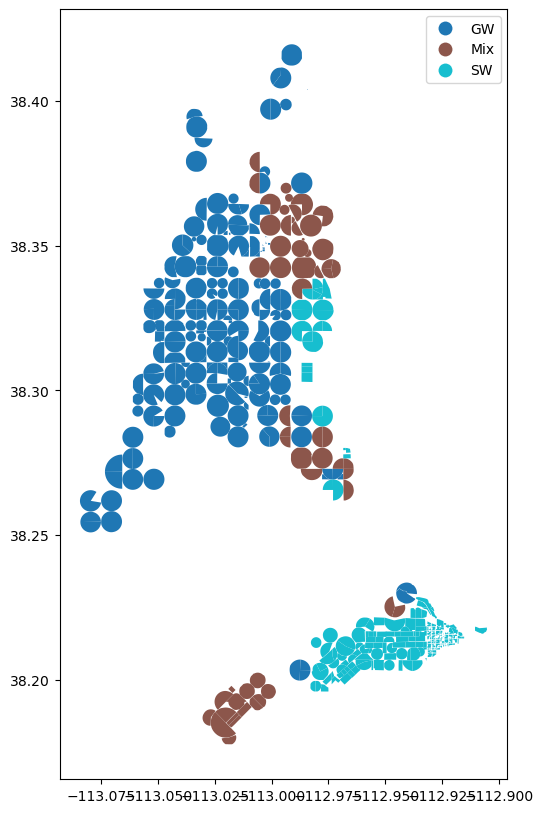

In [52]:
fields.plot(column='WaterSourc',legend=True, figsize=(10,10))
#plt.legend()

<Axes: >

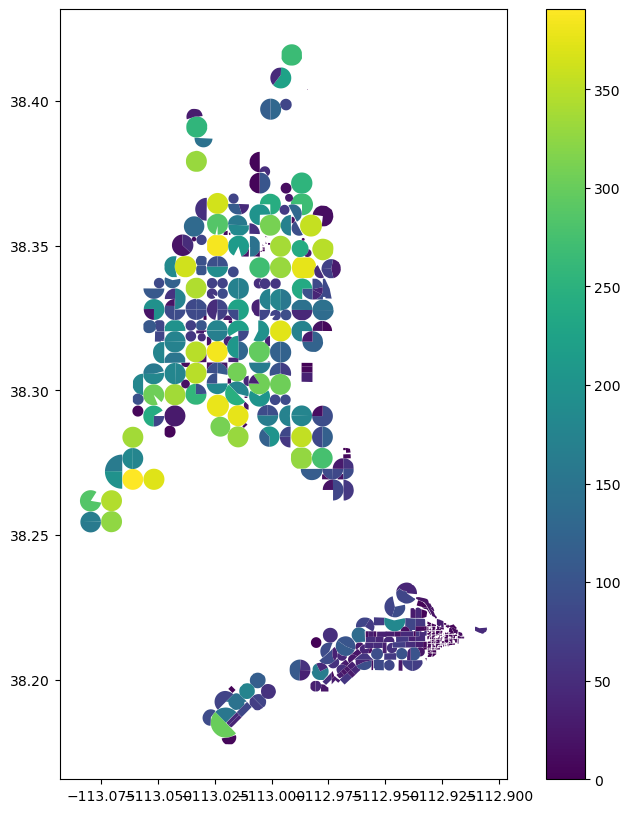

In [53]:
fields.plot(column=2000,legend=True, figsize=(10,10))
#plt.legend()

In [36]:
usgs_irr = {1994: 52400,
            1995: 46200,
            1996: 44600,
            1997: 45000,
            1998: 32700,
            1999: 31800,
            2000: 39600,
            2001: 33500,
            2002: 42500,
            2003: 40300,
            2004: 35800,
            2005: 31400,
            2006: 36400,
            2007: 40600,
            2008: 40300,
            2009: 45600,
            2010: 41100,
            2011: 32200,
            2012: 44700,
            2013: 45900,
            2014: 45700,
            2015: 44900,
            2016: 45000,
            2017: 46800,
            2018: 59584,
            2019: 39912,
            2020: 46863,
            2021: 47423,
            2022: 52662,
            2023: 38735,
            }

In [61]:
app = pd.read_csv("G:/My Drive/Milford_OpenET/applied_water_out/masked_et_pr_applied_acrefeet_summary.csv")
app['month'] = pd.to_datetime(app['month'])
app.set_index('month', inplace=True)
app = app[app.index.month.isin([4,5,6,7,8,9,10])]
appyr = app.groupby(app.index.year).sum()
appyrdict = appyr['applied_acre_feet_masked'].to_dict()


In [62]:
applied = fields.groupby(['WaterSourc'])[list(range(1994,2026))].sum().T
applied['GW + Mixed']= applied['GW'] + applied['Mix']
applied['usgs'] = applied.index.map(lambda x: usgs_irr.get(x))

applied['infiltration'] = applied['usgs'] - applied['GW + Mixed']
applied['ratio'] = applied['infiltration'] / applied['usgs']
applied['whole_raster_consumed'] = applied.index.map(lambda x: appyrdict.get(x))
applied.round(2)

WaterSourc,GW,Mix,SW,GW + Mixed,usgs,infiltration,ratio,whole_raster_consumed
1994,28486.5,7399.3,5943.5,35885.8,52400.0,16514.2,0.32,55485.42
1995,22386.2,6060.5,5158.9,28446.7,46200.0,17753.3,0.38,39788.69
1996,26925.9,7408.3,6306.8,34334.2,44600.0,10265.8,0.23,54080.04
1997,22811.5,6666.3,5508.8,29477.8,45000.0,15522.2,0.34,47823.63
1998,21277.6,6376.3,5073.8,27653.9,32700.0,5046.1,0.15,39694.65
1999,21279.2,6285.8,5099.2,27565.0,31800.0,4235.0,0.13,41561.33
2000,25949.1,7215.8,5670.2,33164.9,39600.0,6435.1,0.16,49350.03
2001,28254.7,7737.3,5820.6,35992.0,33500.0,-2492.0,-0.07,55211.47
2002,25822.3,6942.9,5240.4,32765.2,42500.0,9734.8,0.23,48795.29
2003,26339.3,6965.3,5085.9,33304.6,40300.0,6995.4,0.17,50567.34


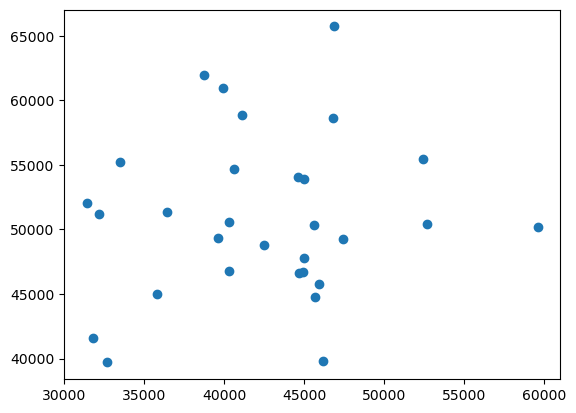

In [63]:
import matplotlib.pyplot as plt
plt.scatter(applied['usgs'],applied['whole_raster_consumed'])

In [3]:
# ---- Paths (adjust if needed) ----
WELLS_PATH = Path("output_tables/wells_with_properties.csv")
FIELDS_PATH = Path("output_tables/fields_by_groupnumber_v2.csv")
OUT_PATH   = Path("output_tables/well_pump_est.csv")

# ---- Configuration ----
YEARS = [2021,2022,2023,2024]
CANAL_DAYS_BY_YEAR = {2021:0, 2022:10, 2023:180, 2024: 180}   # your assumption
GPM_PER_HP_DEFAULT = 8.0                     # fallback if GPM missing
TOTALIZER_MIN_AF   = 1.0                     # treat Totalizer as annual anchor if in this range
TOTALIZER_MAX_AF   = 3000.0

# Deterministic per-well pumping estimator (AF) for 2024 & 2025
# ---- Load ----
wells  = pd.read_csv(WELLS_PATH)
#fields = pd.read_csv(FIELDS_PATH)



wells.columns  = [well_pump.norm(c) for c in wells.columns]
#fields.columns = [well_pump.norm(c) for c in fields.columns]

# ---- Capacity (GPM) per well: use GPM; else HP*rule; else (optional) diameter² factor ----
diam_cols_guess = [c for c in wells.columns if 'diam' in str(c).lower() or 'casing' in str(c).lower()]
diam_col = diam_cols_guess[0] if diam_cols_guess else None


k_diam = well_pump.derive_k_diam(wells, diam_col) if diam_col else None

wells["alloc_capacity_gpm"] = wells.apply(well_pump.compute_capacity_gpm, axis=1)


fld = pd.read_csv(FIELDS_PATH)

for y in YEARS:
    gwf = fld.apply(lambda r: well_pump.gw_fraction(r, y), axis=1)
    fld[f"group_AF_gw_{y}"] = (pd.to_numeric(fld[f"efet_{y}"], errors="coerce") * gwf).clip(lower=0.0)

group_totals = fld.set_index("GROUP_NUMB")[["WaterSourc","watering_days"] + [f"group_AF_gw_{y}" for y in YEARS]]
w = wells.merge(group_totals, on="GROUP_NUMB", how="left")


# ---- Build per-well rows (positional index per group avoids label collisions) ----
rows = []
for y in YEARS:
    gcol = f"group_AF_gw_{y}"
    for group_id, sub in w.groupby("GROUP_NUMB", as_index=False):
        group_total = sub[gcol].iloc[0] if gcol in sub.columns else np.nan
        sub_pos = sub.reset_index(drop=True)
        perwell = well_pump.allocate_group_to_wells(sub_pos, group_total)
        for i, af in enumerate(perwell):
            row = sub_pos.iloc[i]
            rows.append({
                "year": y,
                "GROUP_NUMB": group_id,
                "WIN": row.get("WIN"),
                "WaterSourc": row.get("WaterSourc"),
                "watering_days": row.get("watering_days"),
                "GPM": row.get("GPM"),
                "Horsepower": row.get("Horsepower"),
                "Totalizer": row.get("Totalizer"),
                "alloc_capacity_gpm": row.get("alloc_capacity_gpm"),
                "group_AF_from_wells": group_total,
                "AF_per_well_estimated": float(af),
            })

alloc_df = pd.DataFrame(rows)
alloc_df.to_csv(OUT_PATH, index=False)
print("Wrote:", OUT_PATH)

# ---- Quick QA ----
print("\nSummary by year (total AF from wells):")
print(alloc_df.groupby('year')["AF_per_well_estimated"].sum().round(1))

check = alloc_df.groupby(["year","GROUP_NUMB"]).agg(
    group_level=("group_AF_from_wells","first"),
    sum_of_wells=("AF_per_well_estimated","sum"),
)
check["diff"] = (check["sum_of_wells"] - check["group_level"]).round(6)
print("\nAllocation check (should be ~0 diffs):")
print(check[np.abs(check["diff"]) > 1e-6].head(10))


Wrote: output_tables\well_pump_est.csv

Summary by year (total AF from wells):
year
2021    31974.9
2022    32134.4
2023    34271.0
2024    26215.8
Name: AF_per_well_estimated, dtype: float64

Allocation check (should be ~0 diffs):
Empty DataFrame
Columns: [group_level, sum_of_wells, diff]
Index: []


In [ ]:
!pip install "pymc>=5" arviz pandas numpy
!python /mnt/data/bayes_pumping_model_pymc.py --draws 1500 --tune 1000 --target_accept 0.9


In [ ]:
"""
bayes_pumping_model_pymc.py
------------------------------------------
Bayesian model for per-well annual pumping (acre-feet) with uncertainty.

Data inputs:
  - wells_w_efet.csv       (well-level attributes: GPM, HP, Diameter?, Totalizer, Total_kWh, GROUP_NUMB)
  - fields_by_groupnumb.csv (field-level: efet_2024/2025, WaterSourc, watering_days, ACRES)

Outputs (written to ./bayes_outputs/):
  - posterior_AF_per_well_year.csv
  - posterior_weights_per_well_year.csv
  - idata.nc  (full PyMC InferenceData)

Run example:
  pip install pymc arviz pandas numpy
  python bayes_pumping_model_pymc.py --draws 1500 --tune 1000 --target_accept 0.9
"""

import argparse
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import aesara.tensor as at
from pathlib import Path

# ------------------------------------------------
# CLI arguments
# ------------------------------------------------

parser = argparse.ArgumentParser()
parser.add_argument("--wells", default="/output_tables/wells_with_properties.csv")
parser.add_argument("--fields", default="/output_tables/fields_by_groupnumber_v2.csv")
parser.add_argument("--draws", type=int, default=1000)
parser.add_argument("--tune", type=int, default=1000)
parser.add_argument("--target_accept", type=float, default=0.9)
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--outdir", default="/output_tables/bayes_outputs")
args = parser.parse_args()

np.random.seed(args.seed)
OUTDIR = Path(args.outdir)
OUTDIR.mkdir(parents=True, exist_ok=True)

YEARS = [2024, 2025]
CANAL_DAYS_BY_YEAR = {2024: 170, 2025: 50}
TOTALIZER_MIN_AF = 1.0
TOTALIZER_MAX_AF = 5000.0

# ------------------------------------------------
# Load data
# ------------------------------------------------
def norm(s):
    return s.strip() if isinstance(s, str) else s

wells = pd.read_csv(args.wells)
fields = pd.read_csv(args.fields)
wells.columns = [norm(c) for c in wells.columns]
fields.columns = [norm(c) for c in fields.columns]

# Detect diameter column if present
diam_cols = [c for c in wells.columns if "diam" in str(c).lower()]
diam_col = diam_cols[0] if diam_cols else None

# ------------------------------------------------
# Compute group groundwater demand from field efet and Mix fraction
# ------------------------------------------------
def gw_fraction(row, year):
    ws = str(row.get("WaterSourc", "")).strip().lower()
    wd = pd.to_numeric(row.get("watering_days"), errors="coerce")
    if ws == "gw":
        return 1.0
    if ws == "mix" and pd.notna(wd) and wd > 0:
        canal_days = CANAL_DAYS_BY_YEAR.get(year, 0)
        return max(0.0, (wd - canal_days) / float(wd))
    return 1.0

agg = {"ACRES":"sum", "type":"first", "watering_days":"first", "WaterSourc":"first"}
for y in YEARS:
    agg[f"efet_{y}"] = "sum"

fld = fields.groupby("GROUP_NUMB", as_index=False).agg(agg)
for y in YEARS:
    gwf = fld.apply(lambda r: gw_fraction(r, y), axis=1)
    fld[f"group_AF_gw_{y}"] = (pd.to_numeric(fld[f"efet_{y}"], errors="coerce") * gwf).clip(lower=0.0)

# Merge totals onto wells
group_totals = fld.set_index("GROUP_NUMB")[["WaterSourc", "watering_days"] + [f"group_AF_gw_{y}" for y in YEARS]]
w = wells.merge(group_totals, on="GROUP_NUMB", how="left")

# ------------------------------------------------
# Build data arrays
# ------------------------------------------------
groups = w["GROUP_NUMB"].values
group_ids, group_index = np.unique(groups, return_inverse=True)
G = len(group_ids)
N = len(w)
Y = len(YEARS)

group_demand = np.stack([
    fld.set_index("GROUP_NUMB")[f"group_AF_gw_{y}"].reindex(group_ids).values for y in YEARS
], axis=1)  # G x Y
group_demand_by_well = group_demand[group_index, :]  # N x Y

log_gpm_obs = np.log(pd.to_numeric(w["GPM"], errors="coerce"))
hp = pd.to_numeric(w["Horsepower"], errors="coerce")
hp_log = np.log1p(hp)
diam = pd.to_numeric(w[diam_col], errors="coerce") if diam_col else None
d2_log = np.log1p(diam**2) if diam_col is not None else None
totalizer = pd.to_numeric(w["Totalizer"], errors="coerce")
is_tot_anchor = (totalizer >= TOTALIZER_MIN_AF) & (totalizer <= TOTALIZER_MAX_AF)

# ------------------------------------------------
# Build PyMC model
# ------------------------------------------------
with pm.Model() as model:
    # Log-GPM capacity model
    mu_loggpm = pm.Normal("mu_loggpm", mu=4.5, sigma=1.5)
    sigma_loggpm = pm.HalfNormal("sigma_loggpm", sigma=1.0)
    b_hp = pm.Normal("b_hp", mu=0.5, sigma=0.5)
    if d2_log is not None:
        b_d2 = pm.Normal("b_d2", mu=0.5, sigma=0.5)
        mu_i = mu_loggpm + b_hp * np.nan_to_num(hp_log, 0) + b_d2 * np.nan_to_num(d2_log, 0)
    else:
        mu_i = mu_loggpm + b_hp * np.nan_to_num(hp_log, 0)
    log_gpm_latent = pm.Normal("log_gpm_latent", mu=mu_i, sigma=sigma_loggpm, shape=N)

    # Observed GPM likelihood
    gpm_mask = np.isfinite(log_gpm_obs)
    pm.Normal("log_gpm_obs_like", mu=log_gpm_latent[gpm_mask], sigma=0.25, observed=log_gpm_obs[gpm_mask])

    # Allocation weights per group-year (logistic-normal)
    beta_cap = pm.Normal("beta_cap", mu=1.0, sigma=0.5)
    a_g_y = pm.Normal("a_g_y", mu=0.0, sigma=0.5, shape=(G, Y))
    sigma_eps = pm.HalfNormal("sigma_eps", sigma=1.0)
    eps_i_y = pm.Normal("eps_i_y", mu=0.0, sigma=sigma_eps, shape=(N, Y))

    center = pm.Deterministic("center_log_gpm", at.mean(log_gpm_latent))
    logits = a_g_y[group_index, :] + beta_cap * (log_gpm_latent[:, None] - center) + eps_i_y

    # Normalize weights within each group-year (softmax)
    exp_logits = at.exp(logits)
    weights = at.zeros_like(exp_logits)
    for yi in range(Y):
        sums = at.zeros(G)
        sum_vec = [at.sum(exp_logits[group_index == g, yi]) for g in range(G)]
        sums = at.as_tensor_variable(sum_vec)
        w_y = at.zeros(N)
        for g in range(G):
            mask = group_index == g
            w_y = at.set_subtensor(w_y[mask], exp_logits[mask, yi] / (sums[g] + 1e-9))
        weights = at.set_subtensor(weights[:, yi], w_y)

    pm.Deterministic("weights", weights)

    # Well AF = weight × group demand
    group_demand_tt = at.as_tensor_variable(group_demand_by_well)
    AF_well = pm.Deterministic("AF_well", weights * group_demand_tt)

    # Likelihood: Totalizer (log-space)
    sigma_tot = pm.HalfNormal("sigma_tot", sigma=0.5)
    if is_tot_anchor.any():
        pm.LogNormal(
            "totalizer_like",
            mu=at.log(AF_well[is_tot_anchor, 0] + 1e-6),
            sigma=sigma_tot,
            observed=totalizer[is_tot_anchor],
        )

    # Sample
    idata = pm.sample(
        draws=args.draws, tune=args.tune, chains=4,
        target_accept=args.target_accept, random_seed=args.seed
    )

    # Summaries
    af = idata.posterior["AF_well"].stack(sample=("chain","draw")).transpose("sample","dim_0","dim_1")
    af_np = af.values
    def summarize(arr):
        lo = np.percentile(arr, 5, axis=0)
        med = np.percentile(arr, 50, axis=0)
        hi = np.percentile(arr, 95, axis=0)
        return lo, med, hi
    lo, med, hi = summarize(af_np)

    rows = []
    for i in range(N):
        for yi, year in enumerate(YEARS):
            rows.append({
                "WIN": w.loc[i, "WIN"],
                "GROUP_NUMB": w.loc[i, "GROUP_NUMB"],
                "year": year,
                "AF_lo5": lo[i, yi],
                "AF_med": med[i, yi],
                "AF_hi95": hi[i, yi],
            })
    post_df = pd.DataFrame(rows)
    post_df.to_csv(OUTDIR / "posterior_AF_per_well_year.csv", index=False)

    # Also export weight summaries
    wt = idata.posterior["weights"].stack(sample=("chain","draw")).transpose("sample","dim_0","dim_1").values
    lo_w, med_w, hi_w = summarize(wt)
    rows_w = []
    for i in range(N):
        for yi, year in enumerate(YEARS):
            rows_w.append({
                "WIN": w.loc[i, "WIN"],
                "GROUP_NUMB": w.loc[i, "GROUP_NUMB"],
                "year": year,
                "w_lo5": lo_w[i, yi],
                "w_med": med_w[i, yi],
                "w_hi95": hi_w[i, yi],
            })
    post_w = pd.DataFrame(rows_w)
    post_w.to_csv(OUTDIR / "posterior_weights_per_well_year.csv", index=False)

    az.to_netcdf(idata, OUTDIR / "idata.nc")
    print(f"Saved results in {OUTDIR}")


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


AttributeError: `np.obj2sctype` was removed in the NumPy 2.0 release. Use `np.dtype(obj).type` instead.